In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
df1 = pd.read_csv('trump-tweets-raw(data-world).csv',encoding='Latin-1')

In [2]:
df = pd.read_csv('Donald-Tweets!.csv',encoding='Latin-1')

In [3]:
df.head()

,Date,Time,Tweet_Text,Type,Media_Type,Hashtags,Tweet_Id,Tweet_Url,twt_favourites_IS_THIS_LIKE_QUESTION_MARK,Retweets,Unnamed: 10,Unnamed: 11
0,16-11-11,15:26:37,Today we express our deepest gratitude to all ...,text,photo,ThankAVet,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,127213,41112,NaN,NaN
1,16-11-11,13:33:35,Busy day planned in New York. Will soon be mak...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,141527,28654,NaN,NaN
2,16-11-11,11:14:20,Love the fact that the small groups of protest...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,183729,50039,NaN,NaN
3,16-11-11,2:19:44,Just had a very open and successful presidenti...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,214001,67010,NaN,NaN
4,16-11-11,2:10:46,A fantastic day in D.C. Met with President Oba...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,178499,36688,NaN,NaN


In [4]:
df[df['Date']=='16-08-08']

,Date,Time,Tweet_Text,Type,Media_Type,Hashtags,Tweet_Id,Tweet_Url,twt_favourites_IS_THIS_LIKE_QUESTION_MARK,Retweets,Unnamed: 10,Unnamed: 11
1140,16-08-08,23:18:42,"As Senator Clinton promised 200,000 jobs in Up...",text,photo,NaN,7.630000e+17,https://twitter.com/realDonaldTrump/status/762...,17785,7962,NaN,NaN
1141,16-08-08,22:45:33,Many people are saying that the Iranians kille...,text,NaN,NaN,7.630000e+17,https://twitter.com/realDonaldTrump/status/762...,34214,13469,NaN,NaN
1142,16-08-08,22:43:56,Thank you Newt! https://t.co/Acg0hMvrpr,text,NaN,NaN,7.630000e+17,https://twitter.com/realDonaldTrump/status/762...,25622,9019,NaN,NaN
1143,16-08-08,22:27:02,Thank you Congressman Steven Palazzo! https://...,text,photo,NaN,7.630000e+17,https://twitter.com/realDonaldTrump/status/762...,16813,6173,NaN,NaN
1144,16-08-08,22:24:09,Thank you Senator David Perdue!\nhttps://t.co/...,link,photo,NaN,7.630000e+17,https://twitter.com/realDonaldTrump/status/762...,15824,6197,NaN,NaN
1145,16-08-08,22:20:31,Thank you @RepLouBarletta!\nhttps://t.co/bre8u...,text,photo,NaN,7.630000e+17,https://twitter.com/realDonaldTrump/status/762...,13848,4721,NaN,NaN
1146,16-08-08,22:15:44,Thank you @NFIB- together we will #MakeAmerica...,text,NaN,MakeAmericaGreatAgain,7.630000e+17,https://twitter.com/realDonaldTrump/status/762...,13526,4574,NaN,NaN
1147,16-08-08,22:12:21,Thank you! https://t.co/4p0hzpkVWF,text,NaN,NaN,7.630000e+17,https://twitter.com/realDonaldTrump/status/762...,12272,3654,NaN,NaN
1148,16-08-08,22:06:25,Thank you Alex! https://t.co/c2uIa7mndP,text,NaN,NaN,7.630000e+17,https://twitter.com/realDonaldTrump/status/762...,13384,4291,NaN,NaN
1149,16-08-08,20:14:57,RT @NFIB: .@NFIB encouraged by @realDonaldTrum...,link,NaN,taxplan;smallbiz,7.630000e+17,https://twitter.com/realDonaldTrump/status/762...,8115,3356,NaN,NaN


In [5]:
df1.tail()

,id,source,text,created
2337,734938503541325825,Android,Much of the money I have raised for our vetera...,2016-05-24T02:46:08Z
2338,734936659851128832,Android,"While under no obligation to do so, I have rai...",2016-05-24T02:38:48Z
2339,734903156589645824,iPhone,Join me in California or Montana!\n5/25/16: An...,2016-05-24T00:25:41Z
2340,734892328637325312,Android,I will be interviewed on @oreillyfactor at 8:0...,2016-05-23T23:42:39Z
2341,734742416494845952,Android,"In trade, military and EVERYTHING else, it wil...",2016-05-23T13:46:57Z


In [6]:
#Create two new columns for date and time 
import re
df1['Date'] = df1['created'].str.replace(r'T(\d\d):(\d\d):(\d\d)Z','')
df1['Time'] = df1['created'].str.replace(r'(\d\d\d\d)-(\d\d)-(\d\d)T','').str.replace(r'Z','')

In [7]:
#Remove uncessary columns 
columns = ['Type','Media_Type','Hashtags','Tweet_Id','Tweet_Url','twt_favourites_IS_THIS_LIKE_QUESTION_MARK','Retweets','Unnamed: 10','Unnamed: 11']
df = df.drop(columns,axis=1)
df.tail()


,Date,Time,Tweet_Text
7370,15-07-16,13:10:00,I loved firing goofball atheist Penn @pennjill...
7371,15-07-16,10:18:31,I hear @pennjillette show on Broadway is terri...
7372,15-07-16,10:10:17,Irrelevant clown @KarlRove sweats and shakes n...
7373,15-07-16,9:44:07,"""@HoustonWelder: Donald Trump is one of the se..."
7374,15-07-16,0:21:25,RT @marklevinshow: Trump: Rove is a clown and ...


In [8]:
columns = ['id','source','created']
df1 = df1.drop(columns,axis=1)
df1

,text,Date,Time
0,"The #AmazonWashingtonPost, sometimes referred ...",2017-06-28,13:06:14
1,Some of the Fake News Media likes to say that ...,2017-06-28,10:58:59
2,The failing @nytimes writes false story after ...,2017-06-28,10:49:22
3,I just finished a great meeting with the Repub...,2017-06-27,22:27:48
4,"With ZERO Democrats to help, and a failed, exp...",2017-06-27,22:22:55
...,...,...,...
2337,Much of the money I have raised for our vetera...,2016-05-24,02:46:08
2338,"While under no obligation to do so, I have rai...",2016-05-24,02:38:48
2339,Join me in California or Montana!\n5/25/16: An...,2016-05-24,00:25:41
2340,I will be interviewed on @oreillyfactor at 8:0...,2016-05-23,23:42:39


In [9]:
#Update the year with 4-digit
df['Date'] = df['Date'].str.replace(r'^()','20')
df.tail()

,Date,Time,Tweet_Text
7370,2015-07-16,13:10:00,I loved firing goofball atheist Penn @pennjill...
7371,2015-07-16,10:18:31,I hear @pennjillette show on Broadway is terri...
7372,2015-07-16,10:10:17,Irrelevant clown @KarlRove sweats and shakes n...
7373,2015-07-16,9:44:07,"""@HoustonWelder: Donald Trump is one of the se..."
7374,2015-07-16,0:21:25,RT @marklevinshow: Trump: Rove is a clown and ...


In [10]:
#Rename & capatilize first letter of a column
df.rename(columns={'Tweet_Text':'Text'}, inplace=True)
df1.rename(columns={'text':'Text'}, inplace=True)

In [11]:
#Change column order 
#Change the time format from x:xx:xx to xx:xx:xx
#and merge the dataframe together 

df = df[['Text','Date','Time']]
df['Time'] = df['Time'].str.replace(r'^(\d):(\d\d):(\d\d)',r'0\1:\2:\3')


In [12]:
df.tail() #2016-11 2015-07
#df[df['Date'] == '2016-11-11']

,Text,Date,Time
7370,I loved firing goofball atheist Penn @pennjill...,2015-07-16,13:10:00
7371,I hear @pennjillette show on Broadway is terri...,2015-07-16,10:18:31
7372,Irrelevant clown @KarlRove sweats and shakes n...,2015-07-16,10:10:17
7373,"""@HoustonWelder: Donald Trump is one of the se...",2015-07-16,09:44:07
7374,RT @marklevinshow: Trump: Rove is a clown and ...,2015-07-16,00:21:25


In [13]:
df1.tail() #2017-06 2016-05
df1[df1['Date'] == '2016-11-11']

,Text,Date,Time
1791,Today we express our deepest gratitude to all ...,2016-11-11,15:26:37
1792,Busy day planned in New York. Will soon be mak...,2016-11-11,13:33:35
1793,Love the fact that the small groups of protest...,2016-11-11,11:14:20
1794,Just had a very open and successful presidenti...,2016-11-11,02:19:44
1795,A fantastic day in D.C. Met with President Oba...,2016-11-11,02:10:46


In [33]:
df_merged = pd.concat([df,df1])
#df_merged = merged.copy()#df1[df1['Date']=='2016-08-08'].copy()
df_merged = df_merged.reset_index()


In [34]:
# Plot the first five lines of text
for text in df_merged['Text'][:5]:
    print(text)

Today we express our deepest gratitude to all those who have served in our armed forces. #ThankAVet https://t.co/wPk7QWpK8Z
Busy day planned in New York. Will soon be making some very important decisions on the people who will be running our government!
Love the fact that the small groups of protesters last night have passion for our great country. We will all come together and be proud!
Just had a very open and successful presidential election. Now professional protesters, incited by the media, are protesting. Very unfair!
A fantastic day in D.C. Met with President Obama for first time. Really good meeting, great chemistry. Melania liked Mrs. O a lot!


In [35]:

def cleaning(x):
    
    
    x = re.sub(r"http.+",'', x) #remove URL
    #x = re.sub(r"(\w)([A-Z])", r"\1 \2",x) #Space before capital letters
    #x = x.lower() # Convert upercase to lowercase
    x = re.sub(r"[&]\S*\s",'',x) # remove words starting with & like &amp
    x = re.sub(r"[^a-zA-Z]",' ', x) # Remove non-letters
   
    x = re.sub(r"\s+",' ', x) # replace several spaces with one space
    #x = re.sub(r"^RT.*$",'',x) # remove all retweets
    
   # x = x.strip()
    #x.replace("@\S*",'',regex=True,inplace=True)
    #x.replace("[\n]",'',regex=True,inplace=True)
    return x

df_merged['Text'] = df_merged.apply(lambda x: cleaning(str(x['Text'])),axis=1)
for text in df_merged['Text']:
    print(text)

Today we express our deepest gratitude to all those who have served in our armed forces ThankAVet 
Busy day planned in New York Will soon be making some very important decisions on the people who will be running our government 
Love the fact that the small groups of protesters last night have passion for our great country We will all come together and be proud 
Just had a very open and successful presidential election Now professional protesters incited by the media are protesting Very unfair 
A fantastic day in D C Met with President Obama for first time Really good meeting great chemistry Melania liked Mrs O a lot 
Happy st birthday to the U S Marine Corps Thank you for your service 
Such a beautiful and important evening The forgotten man and woman will never be forgotten again We will all come together as never before
Watching the returns at pm ElectionNight MAGA 
RT IvankaTrump Such a surreal moment to vote for my father for President of the United States Make your voice heard and

 Donald Trump Plans To Continue GOP Legacy Of Leading On Women s Civil Rights Against Racist Sexist Democrats 
The great boxing promoter Don King just endorsed me Nice 
Will be interviewed on FoxNews by JudgeJeanine tonight at P M Enjoy 
Hillary Clinton is unfit to be president She has bad judgement poor leadership skills and a very bad and destructive track record Change 
I am watching CNN very little lately because they are so biased against me Shows are predictable garbage CNN and MSM is one big lie 
The Clinton News Network sometimes referred to as CNN is getting more and more biased They act so indignant hear them behind closed doors
 sareed Our ineffective POTUS has to make a speech in Elkhart to make everything look great Mr Trump MakeAmericaGreatAgain 
I will be interviewed by JudgeJeanine tonight at pm on FoxNews Enjoy 
Thank you Attorney General Gonzales so many people feel this way 
We just had the worst jobs report since 
The Mayor of San Jose did a terrible job of ordering

Victory press conference was over Why is she allowed to grab me and shout questions Can I press charges 
Why arent people looking at this reporters earliest statement as to what happened that is before she found out the episode was on tape 
Wow Corey Lewandowski my campaign manager and a very decent man was just charged with assaulting a reporter Look at tapes nothing there 
How come the TODAYshow chucktodd show the new NBCNews Poll for Hillary vs Bernie but do not show the SAME poll where I am killing Cruz 
I have millions more votes hundreds more dels than Cruz or Kasich and yet am not being treated properly by the Republican Party or the RNC 
Wow CNN has nothing but my opponents on their shows Really one sided and unfair reporting Maybe I shouldnt do their town hall tonight 
We need to secure our borders ASAP No games we must be smart tough and vigilant MAKE AMERICA GREAT AGAIN MAKE AMERICA STRONG AGAIN 
Lyin Ted I have already beaten you in all debates and am way ahead of you in vo

Thank you VoteTrump 
My nomination would increase voter turnout VoteTrump MakeAmericaGreatAgain Trump 
Sadly there is no way that Ted Cruz can continue running in the Republican Primary unless he can erase doubt on eligibility Dems will sue 
 johnkurkosky Carolde The Lady Colors DRJAMESCABOT TamiDurling AceofSpadesHQ THIS ELECTION IS ABOUT AMERICAS FUTURE VOTE TRUMP 
Thank you for your support last night Iowa VoteTrump Trump IACaucus FITN IAPolitics 
Iran toys with U S days before we pay them ridiculously billions of dollars Dont release money We want our hostages back NOW 
Numerous polls have me beating Hillary Clinton In a race with her voter turnout will be the highest in U S history I get most new voters 
The State Of The Union speech was one of the most boring rambling and non substantive I have heard in a long time New leadership fast 
Just found out that tedcruz is spending a fortune on Iowa push polls negative to me Not nice but OK New polls are great 
The SOTU speech is really

Todays WSJ Editorial is WRONG again I know that China is not in the new T P P trade deal but would come in latter through a back door 
I will be interviewed on MariaBartiromo FoxBusiness at 
All seven on line polls including Drudge and Time with thousands of respondents said I won the debate krauthammer said I was so so 
 ellenEspence Im not convinced that any candidate other than realDonaldTrump is committed to securing our borders VoteTrump 
 BornToBeGOP realDonaldTrump You will bring out more voters to vote for you than weve seen in any election Great 
 frankieguy This Year Old Woman Registered to Vote Just to Cast a Ballot for Trump 
 Christianlord RUBIO sat back during debate on Immigration hoping no would ask him about Gang of 
Will be interviewed by oreillyfactor tonight at PM 
I will be on marklevinshow at PM tonight Tune in 
 gerardtbaker Gerardwonderful job last night as moderator of the debate I told many really smart and elegant 
I never said that China was in the bad TPP t

 THR The Donald Trump Ratings Bump Whos Benefiting Most 
RT sethweathers New Poll realDonaldTrump maintains huge lead in Georgia Trump 
 TheHill Trump on Boehner resignation Its a good thing 
 Has worst attendance record in Senate rarely there to vote on a bill marcorubio
 MarcoRubio is weak on illegal immigration and will allow anyone into the country 
Dishonest politico just called to say that none of the polls including Fox NBC CNN Zogby Morning Consult matter Serious haters 
At the Old Post Office 
I am now inspecting the Old Post Office on Pennsylvania Avenue will be a great hotel Soon off to the Oklahoma State Fair 
 Ahead of schedule and under budget Will be in Oklahoma tonight 
Great reception in D C At the Values Voter Summit Now checking on my job at the Old Post Office 
RT daveweigel Packed VVS ballroom for realDonaldTrump Biggest classiest crowd so far 
 Rketeltas JoeMarzocco Waiting for the biased media to write about the Carly fired as a failed CEO America is for Trump 
 

 vince The left wing politically correct cannot handle big don giving the truth reality keep saying it like it is 
 pg rant They cant handle you Donald so want you out the race well good luck because we know you wont walk away Give it to them 
 HL tweets McCain epitomizes the career politicians who have gotten us into our TRILLION train wreck including the VA debacle 
My USATOpinion piece Trump I dont need to be lectured 
I will be making some very big campaign stops next week big crowds and tremendous energy MAKE AMERICA GREAT AGAIN
The Republican Party must get tougher and smarter and fast or it will go down to a very big defeat just like the last two times 
A true piece about the standing ovations I got yesterday 
The Veterans Administration is in shambles and our veterans are suffering greatly John McCain has done nothing to help them but talk 
John McCain called thousands of people crazies when they came to seek help on illegal immigration last week in Phoenix He owes apology 
RT 

I am on oreillyfactor tonight a big special FoxNews at P M ENJOY 
Bill O Reilly doing a major special on OreillyFactor tonight FoxNews at pmE Watch it should be good Trump 
AN AMERICA FIRST ENERGY PLAN MakeAmericaGreatAgain Trump 
Poll data shows that marcorubio does by far the best in holding onto his Senate seat in Florida Important to keep the MAJORITY Run Marco 
My wife MELANIATRUMP and my children will be featured on FoxNews with Greta pmE Enjoy MeetTheTrumps Trump 
Celebrating Trump 
Thank you Trump 
I find it offensive that Goofy Elizabeth Warren sometimes referred to as Pocahontas pretended to be Native American to get in Harvard 
Thank you Mr Mrs TomBarrackJr for the wonderful and magical evening last night It will not be forgotten Trump 
 kimguilfoyle just watched you on OutnumberedFNC thank you 
The Inspector General s report on Crooked Hillary Clinton is a disaster Such bad judgement and temperament cannot be allowed in the W H 
Thank you Anaheim California Trump 
Thank you

I won every poll from last nights Presidential Debate except for the little watched CNN poll 
 How Trump won over a bar full of undecideds and Democrats 
I really enjoyed the debate last night Crooked Hillary says she is going to do so many things Why hasn t she done them in her last years 
Great debate poll numbers I will be on foxandfriends at to discuss Enjoy 
Thank you Four new DebateNight polls with the MOVEMENT winning Together we will MAKE AMERICA SAFE GREAT AGAIN 
 DRUDGE REPORT s First Presidential Debate Poll Trump Clinton Join the MOVEMENT today lets MAGA 
Thank you CNBC DebateNight poll with over votes Trump Clinton AmericaFirst ImWithYou 
TIME DebateNight poll over votes Thank you AmericaFirst MAGA 
 newtgingrich just said a historic victory for Trump NICE 
Wow did great in the debate polls except for CNN which I don t watch Thank you 
Thank you Governor TerryBranstad AmericaFirst Debates 
Thank you Governor Mike Pence Lets MAKE AMERICA SAFE AND GREAT AGAIN with the Americ

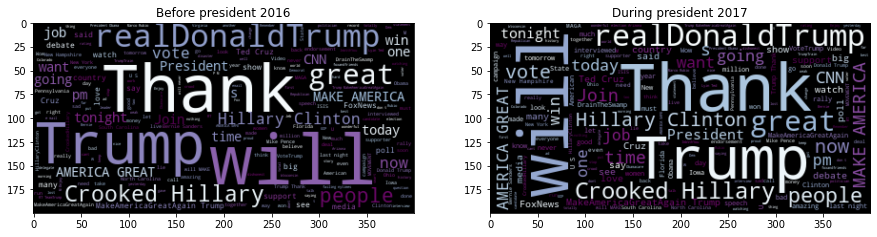

In [36]:
text2016 = df_merged[(df_merged['Date'] >='2016-01-01') & (df_merged['Date'] <='2016-12-31')]['Text']
lst_text2016 = []
lst_text2016.append(' '.join(text for text in text2016))

text2017 = df_merged[(df_merged['Date'] >='2017-01-01') & (df_merged['Date'] <='2017-06-15')]['Text']
lst_text2017 = []
lst_text2017.append(' '.join(text for text in text2017))

fig, axes = plt.subplots(1,2,squeeze=False,figsize=(15,15))

wordcloud2016 = WordCloud(max_words=200, background_color="black",
                          colormap='BuPu').generate(lst_text2016[0])

wordcloud2017 = WordCloud(max_words=200, background_color="black",
                          colormap='BuPu').generate(lst_text2016[0])
axes[0][0].imshow(wordcloud2016, interpolation='bilinear')
axes[0][1].imshow(wordcloud2017, interpolation='bilinear')
axes[0][0].title.set_text('Before president 2016')
axes[0][1].title.set_text('During president 2017')
#axes[0][0].axis("off")
#axes[0][0].title('2016 before president')
plt.show()


In [17]:
cv = CountVectorizer(stop_words='english')
text_cv = cv.fit_transform(df_merged['Text'])
#df_text = pd.DataFrame(text_cv.toarray(), columns=cv.get_feature_names())
#df_text.index = df_merged.index
text_cv.toarray()
for i in cv.vocabulary_.keys():
    print(i.keys())

AttributeError: 'str' object has no attribute 'keys'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
      'This is the first document.',
      'This document is the second document.',
      'And this is the third one.',
      'Is this the first document?'
 ]
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.toarray())
pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

In [24]:
for text in df_merged['Text']:
    print(text)

Today we express our deepest gratitude to all those who have served in our armed forces ThankAVet 
Busy day planned in New York Will soon be making some very important decisions on the people who will be running our government 
Love the fact that the small groups of protesters last night have passion for our great country We will all come together and be proud 
Just had a very open and successful presidential election Now professional protesters incited by the media are protesting Very unfair 
A fantastic day in D C Met with President Obama for first time Really good meeting great chemistry Melania liked Mrs O a lot 
Happy st birthday to the U S Marine Corps Thank you for your service 
Such a beautiful and important evening The forgotten man and woman will never be forgotten again We will all come together as never before
Watching the returns at pm ElectionNight MAGA 
RT IvankaTrump Such a surreal moment to vote for my father for President of the United States Make your voice heard and

Arriving TrumpScotland with DonaldJTrumpJr amp EricTrump Back to New York tonight Video 
So funny Crooked Hillary called BREXIT so incorrectly and now she says that she is the one to deal with the U K All talk no action 
Thoughts and prayers are with everyone in West Virginia dealing with the devastating floods ImWithYou
 Jolena realDonaldTrump And we will get it back once we have President Trump Cant wait 
 DarrenWaggener realDonaldTrump What has happened in the UK in the last hours is exactly what will happen in November vote TRUMP 
Many people are equating BREXIT and what is going on in Great Britain with what is happening in the U S People want their country back 
The opening of Trump Turnberry in Scotland was a big success Good timing I was here for BREXIT Very exciting news conference today 
Crooked Hillary called it totally wrong on BREXIT she went with Obama and now she is saying we need her to lead She would be a disaster
I want all Americans to succeed together President Obam

While I have never met nytdavidbrooks of the NY Times I consider him one of the dumbest of all pundits he has no sense of the real world 
Heading to Phoneix Will be arriving soon Tomorrow a big day Tremendous crowds expected Trump MakeAmericaGreatAgain
Watching loudobbsnews fantastic show Has very interesting take on Paul Ryan 
Just leaving Salt Lake City Utah fantastic crowd with no interruptions Love Utah will be back 
RT MarkHalperin Utah Speaker of the House announces endorsement of realDonaldTrump Says DonaldJTrumpJr played a big role
Why havent they released the final Missouri victory for us yet Could it be because Cruzs guy runs Missouri 
I guess I have reached yet another ceiling with four people My highest Reuters poll yet Thank you 
Do you believe that Hillary Clinton now wants Obamacare for illegal immigrants She should spend more time taking care of our great Vets 
Everybody should boycott the megynkelly show Never worth watching Always a hit on Trump She is sick amp the mo

Thank you New Hampshire FITN Trump NHPolitics 
Thank you Florida Trump 
 K in OK Had to turn away k but we are coming back soon to take care of them So much love in the crowd Thanks 
RT SarahPalinUSA Trading in the beautiful snow of Iowa for the red dirt of Oklahoma as planned despite what the media is trys no htt 
Great rally in Iowa Such wonderful people Traveling now with SarahPalinUSA to Tulsa massive crowd expected 
 MakeAmericaGreatAgain Trump LIFE CHANGING EXPERIENCE Video 
Will be interviewed on foxandfriends at A M Eastern Enjoy 
I wil be interviewed on the TODAYshow at A M Enjoy 
 nytimes Breaking News Sarah Palin has endorsed Donald Trump in the GOP primary appeal to Tea Party loyalists 
 ron fournier President Donald Trump just getting used to it Wow very nice 
I am greatly honored to receive Sarah Palins endorsement tonight Video 
Judge Jeanine Slams GOP Establishment 
 Trump MakeAmericaGreatAgain ECONOMY VIDEO 
Palin s brand among evangelicals is as gold as the faucets in

 WineChics Trump Winery 
 mcjeff realDonaldTrump you made SNL great again nbcsnl
 SpecialKMB nbcsnl realDonaldTrump was hilarious ty we so enjoyed it TrumpTrainSNL TrumpOnSNL MakeAmericaGreatAgain 
 MyPresidentme EricShawnonFox Thats because people are interested in you amp youve got a great sense of humor unlike Hillary Trump 
 tegodreaux realDonaldTrump EricShawnonFox HUUUUUGE 
 EmitteLucemTuam realDonaldTrump EricShawnonFox Great job Donald Good luck from Canada 
 coltsfan realDonaldTrump EricShawnonFox 
 EricShawnonFox Highest rated Saturday Night Live in four years higher than their opening night with Hillary amp Miley Cyrus Nice words
Television ratings for nbcsnl Saturday Night Live just came out and they were great the best since Very few protesters 
 CleopattraUSA realDonaldTrump nbcsnl Youve got it going on Nothing is boring or low energy about you EverybodyRockW TrumpNow SNL
At I will be interviewed on both meetthepress by chucktodd and CBSNews Face The Nation by John Dicker

 MNTwisterChaser Thanks SavannahGuthrie and NBCNews for showing us how lopsided you are Use your own poll trainwreck Trump 
The TODAYshow refused to use their just in poll numbers where I have a massive lead but instead used CNN numbers where my lead is smaller 
Will be on foxandfriends now Enjoy 
 SaijoSaijo realDonaldTrump thank you for your personal and financial sacrifices to make america great again 
Carly Fiorina did such a horrible job at Lucent and HP virtually destroying both companies that she never got another CEO job offer Pres 
We are going to WIN and MAKE AMERICA GREAT AGAIN maybe better than ever before 
I am attracting the biggest crowds by far and the best poll numbers also by far Much of the media is totally dishonest So sad 
I have been leading big in all polls with two more today nbc and CNN The NBC poll is more than double next at Fiorina has 
There is no way that Carly Fiorina can become the Republican Nominee or win against the Dems Boxer killed her for Senate in

Just left Family Leadership Summit in Iowa got a standing ovation from many wonderful people I will be back soon 
Statement on John McCain 
I am now in Iowa getting ready to speak People are always amazed to find out that I am Protestant Presbyterian GREAT 
The billion net worth is AFTER all debt and liabilities So simple to understand but CNN amp CNNPolitics is just plain dumb 
Ratings starved CNN and CNNPolitics does not cover me accurately Why cant they get it right its really not that hard 
Made a speech in Arkansas last night before a record GOP crowd Great spirit and amazing people MAKE AMERICA GREAT AGAIN 
Its driving ariannahuff amp the money losing HuffingtonPost post crazy that I am in their poll and they only write bad stories about me 
The liberal clown ariannahuff told her minions at the money losing HuffingtonPost to cover me as enterainment I am in Huff Post Poll 
 koltonbittner realDonaldTrump makes me proud to be an American So nice thank you 
 rua ri realDonaldTrump y

Crooked Hillary Clinton has zero natural talent she should not be president Her temperament is bad and her decision making ability zilch 
 HaloDad realDonaldTrump I already voted for you My wife did as well I represent Teachers Trump We represent CA Trump NeverDems
 SCPioneer stockdaleism JamesRosenFNC FoxNews realDonaldTrump Not for slackers Happy w courses I took Thanks 
Thank you Sacramento California MakeAmericaGreatAgain 
Same failing nytimes reporter who wrote discredited women s story last week wrote another terrible story on me today will never learn 
Crooked Hillary Clinton is a fraud who has put the public and country at risk by her illegal and very stupid use of e mails Many missing 
Join me in San Jose California tomorrow evening at pm MakeAmericaGreatAgain Trump 
So I raised gave for the veterans and the media makes me look bad They do anything to belittle totally biased 
Congratulations to seanhannity on his tremendous increase in television ratings Speaking of ratings I 

If Ted Cruz is so opposed to gay marriage why did he accept money from people who espouse gay marriage 
Ted is the ultimate hypocrite Says one thing for money does another for votes 
Great new numbers Thank you MakeAmericaGreatAgain Trump 
Ted Cruz purposely and illegally did not list on his personal disclosure form personally guaranteed loans from banks They own him 
 FoxNews Poll THANK YOU MakeAmericaGreatAgain Trump 
 MakeAmericaGreatAgain Trump 
Love seeing union amp non union members alike are defecting to Trump I will create jobs like no one else Their Dem leaders can t compete 
I hope all workers demand that their Teamsters reps endorse Donald J Trump Nobody knows jobs like I do Don t let them sell you out 
On my way to South Carolina Big Crowd look forward to it 
Hank Greenberg formerly of AIG gave million to the JebBush campaign months ago He is not happy a total waste of money 
 sprinklermanus CNN realDonaldTrump they re spending millions but you re still going to win go Dona

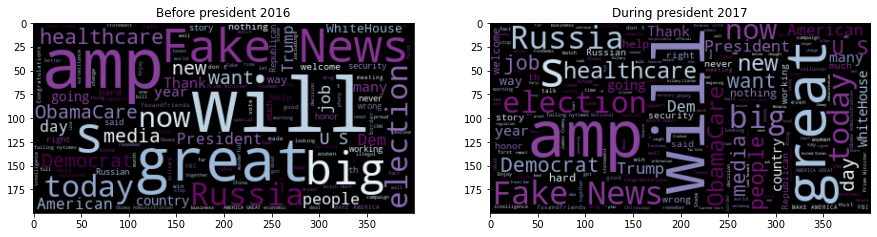

In [25]:
text2016 = df_merged[(df_merged['Date'] >='2016-01-01') & (df_merged['Date'] >='2016-12-31')]['Text']
lst_text2016 = []
lst_text2016.append(' '.join(text for text in text2016))

text2017 = df_merged[(df_merged['Date'] >='2017-01-01') & (df_merged['Date'] >='2017-06-15')]['Text']
lst_text2017 = []
lst_text2017.append(' '.join(text for text in text2017))

fig, axes = plt.subplots(1,2,squeeze=False,figsize=(15,15))

wordcloud2016 = WordCloud(max_words=200, background_color="black",
                          colormap='BuPu').generate(lst_text2016[0])

wordcloud2017 = WordCloud(max_words=200, background_color="black",
                          colormap='BuPu').generate(lst_text2016[0])
axes[0][0].imshow(wordcloud2016, interpolation='bilinear')
axes[0][1].imshow(wordcloud2017, interpolation='bilinear')
axes[0][0].title.set_text('Before president 2016')
axes[0][1].title.set_text('During president 2017')
#axes[0][0].axis("off")
#axes[0][0].title('2016 before president')
plt.show()


In [ ]:
from sklearn.feature_extraction import text 
#for i in df['Text']:
#    print(i)
text.ENGLISH_STOP_WORDS.union(df['Text'][5])


In [ ]:
pol = []
sub = []
for i, text in enumerate(test['Text']):
    pol.append(TextBlob(text).sentiment[0])
    sub.append(TextBlob(text).sentiment[1])


In [ ]:
df_sentiment = pd.DataFrame({'polarity':pol,
                         'subjectivity':sub})

# Concatenate the two dataframes into one
df = pd.concat([test,df_sentiment], axis=1)
df.sort_values(by='Date',inplace=True)
df.head()

In [ ]:
text2017 = df[(df['Date'] >='2017-01-01') & (df['Date'] >='2017-06-15')]['Text']
lst_text = []
lst_text.append(' '.join(text for text in text2017))

wordcloud = WordCloud(max_words=100, background_color="black",colormap='BuPu').generate(lst_text[0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('2017 during president')
plt.show()


In [ ]:
df['date'] = df['Date']+' '+df['Time']
df['date'] = pd.to_datetime(df['date'])
df.info()

In [ ]:
df.drop(columns=['index'],inplace=True)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)
sentiment_week = df.groupby(pd.Grouper(key='date',freq='w')).mean()
sentiment_day = df.groupby(pd.Grouper(key='date',freq='d')).mean()

sentiment_day.plot(alpha=0.7, ax=ax1,figsize=(12,4))
sentiment_week.plot(alpha=0.7, ax=ax2)

In [ ]:
test = df1[df1['Date']=='2016-08-08'].copy()
for i in test['Text']:
    print(i)

#re.sub(r"(?<=\s(http.)).*?(?=\s)",'',test['Text'])
#test['Text'].replace("http.+",'',regex=True,inplace=True)
#test['Text'].replace("@\S*",'',regex=True,inplace=True)
#test['Text'].replace("[\n]",'',regex=True,inplace=True)
#test['Text']

In [ ]:
test['Text'][2235]

In [ ]:
df[df['Date']=='16-08-08']

In [ ]:
df1s = df1.sort_values(by=['Date','Time'])

In [ ]:
df1s[df1s['Date']=='2016-08-08']

In [ ]:
df[df['Date']<='16-05-22'] #2016-11 2015-07